In [5]:
import numpy as np
import pandas as pd

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# 0. Inicializando Ambiente Django no Notebook

Por enquanto não estou utilizando os dados do banco de dados (e sim o csv presente em csv_data/).

Porém no dia 21/05/25 modifiquei o django_for_jupyter.py para que após a reestruturação dos diretórios os notebooks antigos (e também os dentro de classification) possam acessar o BD futuramente.

In [6]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

from django_for_jupyter import init_django
init_django('app')

Django initialized for project: app
Project root added to sys.path: /home/esdras-daniel/Documentos/Python/Django/PGM-Text_Classificator


# 1. Criando Dataset das intimações genéricas do AF

## 1.1 - Recuperando apenas os dados do AF do CSV

In [7]:
notebook_dir = os.getcwd()
csv_file_path = os.path.join(notebook_dir, '..', '..', 'csv_data', 'processed', 'pgm-dataset_clean.csv')
print(f'Caminho do CSV: {csv_file_path}')

df = pd.read_csv(csv_file_path)

Caminho do CSV: /home/esdras-daniel/Documentos/Python/Django/PGM-Text_Classificator/notebooks/classification/../../csv_data/processed/pgm-dataset_clean.csv


In [8]:
df_apoio_fiscal = df[df['setorDestino'] == 'APOIO FISCAL']
print(f'{df_apoio_fiscal.shape}')

(4227, 11)


## 1.2 - Removendo duplicatas

In [9]:
X = df_apoio_fiscal['teorTexto'].drop_duplicates().to_numpy()
print(f'{len(X)}')

4196


## 1.2 - Colocando as Labels de Intimação Genérica

### 1.2.1 - Fazendo matching com os termos que Levi + CSV das initmações genéricas do AF

Termos como 'manifestar-se', 'manifestar', 'requerer o que entender de direito', 'manifestar-se sobre a certidão do Oficial de Justiça'

In [10]:
import re

def verificar_padroes(X, dict_regex, flag=re.IGNORECASE):
    def match(text):
        for padrao in dict_regex.keys():
            if re.search(padrao, text, flags=flag):
                dict_regex[padrao] += 1
                return 1        
        return 0

    if isinstance(X, (list, np.ndarray, pd.Series)):
        return np.array([match(text) for text in X])
    elif isinstance(X, str):
        return match(X)
    else:
        raise TypeError('Entrada deve ser uma string ou uma lista/array de strings.')

dict_regexes = {
    r"intimo\s+a\s+fazenda\s+p[úu]blica.*?manifestar-se.*?certid[aã]o\s+do\s+oficial\s+de\s+justi[çc]a": 0,
    r"manifestar.*?certid[aã]o\s+do\s+oficial\s+de\s+justi[çc]a": 0,
    r"informar\s+o\s+endere[çc]o.*?parte\s+executada.*?cumprimento.*?decis[aã]o": 0,
    r"manifestar.*?fim\s+do\s+parcelamento.*?requer[êe]r?\s+o\s+que\s+entender\s+de\s+direito": 0,
    r"requer[êe]r?\s+o\s+que\s+entender\s+de\s+direito": 0,
    r"requerendo?\s+o?\s+que\s+entender\s+devido": 0
}

resultado = verificar_padroes(X, dict_regexes)

In [11]:
print(f'Usando expressões regulares (regex) foram identificados {resultado.sum()} textos ({(resultado.sum()/len(X))*100:.2f}% do total) do AF')

dict_regexes

Usando expressões regulares (regex) foram identificados 2083 textos (49.64% do total) do AF


{'intimo\\s+a\\s+fazenda\\s+p[úu]blica.*?manifestar-se.*?certid[aã]o\\s+do\\s+oficial\\s+de\\s+justi[çc]a': 1372,
 'manifestar.*?certid[aã]o\\s+do\\s+oficial\\s+de\\s+justi[çc]a': 111,
 'informar\\s+o\\s+endere[çc]o.*?parte\\s+executada.*?cumprimento.*?decis[aã]o': 2,
 'manifestar.*?fim\\s+do\\s+parcelamento.*?requer[êe]r?\\s+o\\s+que\\s+entender\\s+de\\s+direito': 0,
 'requer[êe]r?\\s+o\\s+que\\s+entender\\s+de\\s+direito': 587,
 'requerendo?\\s+o?\\s+que\\s+entender\\s+devido': 11}

In [12]:
# Criando um DataFrame para análise dos dados

df_intimacoes_genericas = pd.DataFrame({'teor_texto':X,
                                        'label':resultado})

df_intimacoes_genericas.head(3)

,teor_texto,label
0,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0
1,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0
2,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0


## 1.3 - Limpando os textos com RegeEx

Podemos cortar os cabeçalhos das intimações usando expressões regulares

In [13]:
def space(word):
    return r'\b' + r'\s*'.join(list(word)) + r'\b'

palavras_cabecalho = [
    'ATO ORDINATÓRIO', 'DESPACHO', 'CERTIDÃO', 'DECISÃO', 'SENTENÇA',
    'INTIMAÇÃO'
]

# Monta um dicionário de regex com variações (normal, espaçado, lowercase)
regex_dict = {
    space(''.join(word.split())):0
    for word in palavras_cabecalho
}

cabecalho_flaged = verificar_padroes(X, regex_dict, flag=0) # Não adiciona flags de ignorecase (ou seja, utiliza o case alto)

In [14]:
regex_dict

{'\\bA\\s*T\\s*O\\s*O\\s*R\\s*D\\s*I\\s*N\\s*A\\s*T\\s*Ó\\s*R\\s*I\\s*O\\b': 2131,
 '\\bD\\s*E\\s*S\\s*P\\s*A\\s*C\\s*H\\s*O\\b': 995,
 '\\bC\\s*E\\s*R\\s*T\\s*I\\s*D\\s*Ã\\s*O\\b': 272,
 '\\bD\\s*E\\s*C\\s*I\\s*S\\s*Ã\\s*O\\b': 754,
 '\\bS\\s*E\\s*N\\s*T\\s*E\\s*N\\s*Ç\\s*A\\b': 39,
 '\\bI\\s*N\\s*T\\s*I\\s*M\\s*A\\s*Ç\\s*Ã\\s*O\\b': 2}

Vemos que conseguimos, ao que parece, identificar corretamente os cabeçalhos. Agora vamos criar uma função que os remove e também remove o rodapé após Natal/RN

In [15]:
def remover_cabecalho_rodape(regex_dict, flag=re.IGNORECASE):
    def extract(text):
        if not isinstance(text, str):
            return text
        
        for pattern in regex_dict.keys():
            match = re.search(pattern, text, flags=flag)
            if match:
                text = text[match.end():]
                break # Usa o primeiro que der match

        # Remove o rodapé se encontrar Natal/RN ou variações
        match_rodape = re.search(r"(?i)N\s*A\s*T\s*A\s*L\s*/\s*R\s*N", text)
        if match_rodape:
            text = text[:match_rodape.start()].strip()
            
        return text.lower()
    return extract

df_intimacoes_genericas['teor_texto_clean'] = df_intimacoes_genericas['teor_texto'].apply(remover_cabecalho_rodape(regex_dict, flag=0))

In [16]:
df_intimacoes_genericas

,teor_texto,label,teor_texto_clean
0,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0,expeça-se alvará em favor do município do na...
1,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0,trata-se de execução fiscal entre as partes ac...
2,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0,"certifico, em razão de meu ofício, que em cump..."
3,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0,"intimo a fazenda pública, para no prazo de ..."
4,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0,"intime-se novamente a exequente para, em 20 (..."
...,...,...,...
4191,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0,remetam-se os autos ao ente público exequente ...
4192,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,0,remetam-se os autos ao ente público exequente ...
4193,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,1,"remetam-se os autos à fazenda pública para, em..."
4194,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,1,"remetam-se os autos à fazenda pública para, em..."


In [17]:
df_intimacoes_genericas['teor_texto'].loc[3000]

'PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NORTE 2ª VARA DE EXECUÇÃO FISCAL E TRIBUTÁRIA COMARCA DE NATAL/RN   Processo nº 0801277-91.2018.8.20.5001 EXECUÇÃO FISCAL (1116) EXEQUENTE: MUNICÍPIO DE NATAL EXECUTADO: MIRADOR EMPREENDIMENTOS IMOBILIARIOS LTDA - ME  DECISÃO  Vistos etc.  Trata-se de EXECUÇÃO FISCAL ajuizada pelo ente público acima nominado contra MIRADOR EMPREENDIMENTOS IMOBILIARIOS LTDA - ME.  Infrutíferas as tentativas de penhora de valores (SISBAJUD) e de veículos (RENAJUD), a parte exequente requereu a realização de penhora sobre o faturamento da empresa (ID 118854121).  É o que importa relatar. Decido.  A priori, importante transcrever o disposto nos arts. 834 e 835, do Código de Processo Civil, no tocante à realização da penhora:  Art. 834. Podem ser penhorados, à falta de outros bens, os frutos e os rendimentos dos bens inalienáveis.  Art. 835. A penhora observará, preferencialmente, a seguinte ordem: I - dinheiro, em espécie ou em depósito ou aplicação em instituiç

In [18]:
np.where(cabecalho_flaged == 0)

(array([ 298, 2638, 3475]),)

In [19]:
# Por não ter conseguido remover o cabeçalho (erro de digitação em 2 casos) vamos remover apenas os dois primeiros indíces acima do dataset.
df_intimacoes_genericas.drop(index=[298, 2638], inplace=True)
df_intimacoes_genericas.reset_index(drop=True, inplace=True) # Resetando os indíces

# 2. Analisando os dados

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

## 2.1 - Comprimento dos textos por classe

In [21]:
df_intimacoes_genericas['qtd. caracteres'] = df_intimacoes_genericas['teor_texto_clean'].apply(len)
df_intimacoes_genericas['qtd. palavras'] = df_intimacoes_genericas['teor_texto_clean'].apply(lambda x: len(x.split()))

In [22]:
df_intimacoes_genericas.groupby('label')[['qtd. palavras', 'qtd. caracteres']].describe()

qtd. palavras                                                           \
              count        mean         std   min   25%   50%    75%     max   
label                                                                          
0            2111.0  205.744671  437.029516   9.0  41.0  59.0  125.0  4538.0   
1            2083.0   55.015362  151.631267  16.0  31.0  31.0   40.0  3930.0   

      qtd. caracteres                                                        \
                count         mean          std    min    25%    50%    75%   
label                                                                         
0              2111.0  1340.256750  2885.544393   61.0  249.0  368.0  789.0   
1              2083.0   331.579933   992.241427  108.0  172.0  172.0  228.0   

                
           max  
label           
0      30211.0  
1      25504.0

Para melhor visualização vamos excluir os extremos (principalmente o máximo)

In [23]:
def remover_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return df[(df[col] >= lim_inf) & (df[col] <= lim_sup)]

# Aplicar para ambas as colunas
df_intimacoes_genericas_sem_outliers = remover_outliers_iqr(df_intimacoes_genericas, 'qtd. caracteres')

### 2.1.1 - Histograma

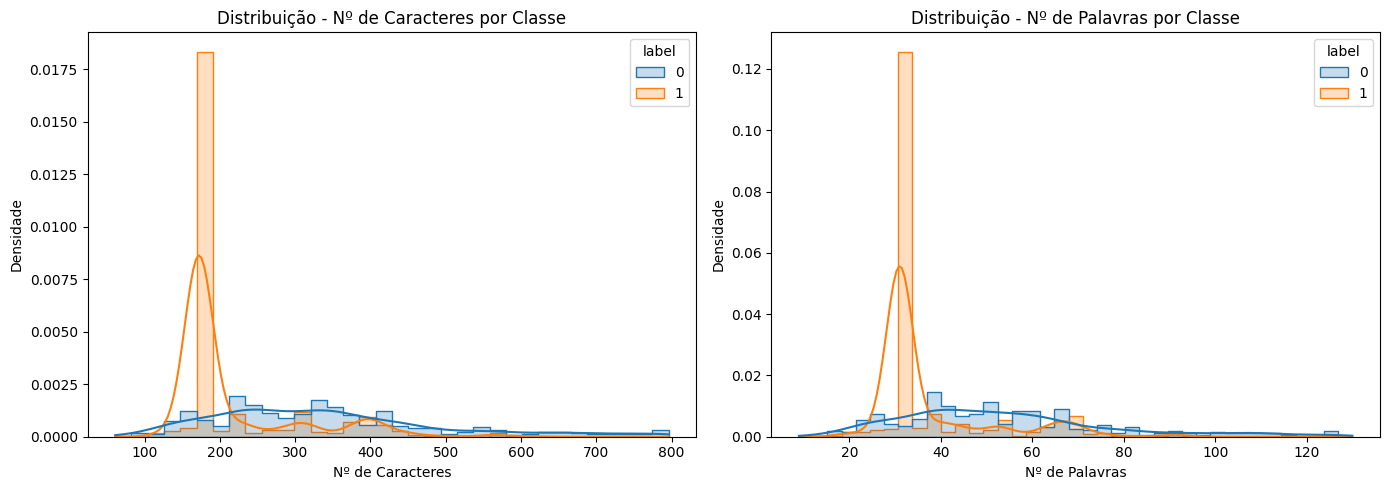

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 - Qtd de caracteres
sns.histplot(data=df_intimacoes_genericas_sem_outliers, x='qtd. caracteres', hue='label', kde=True, element='step', stat='density', ax=axes[0])
axes[0].set_title('Distribuição - Nº de Caracteres por Classe')
axes[0].set_xlabel('Nº de Caracteres')
axes[0].set_ylabel('Densidade')

# Subplot 2 - Qtd de palavras
sns.histplot(data=df_intimacoes_genericas_sem_outliers, x='qtd. palavras', hue='label', kde=True, element='step', stat='density', ax=axes[1])
axes[1].set_title('Distribuição - Nº de Palavras por Classe')
axes[1].set_xlabel('Nº de Palavras')
axes[1].set_ylabel('Densidade')

plt.tight_layout()
plt.show()

### 2.1.2 - Boxplots

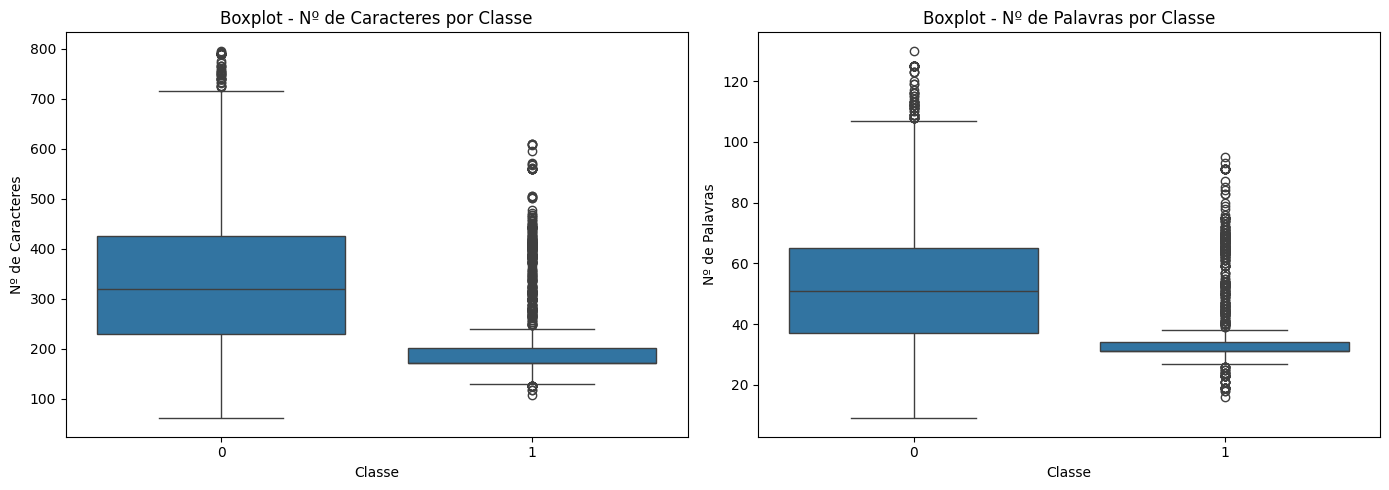

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 - Qtd de caracteres
sns.boxplot(data=df_intimacoes_genericas_sem_outliers, x='label', y='qtd. caracteres', ax=axes[0])
axes[0].set_title('Boxplot - Nº de Caracteres por Classe')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Nº de Caracteres')

# Subplot 2 - Qtd de palavras
sns.boxplot(data=df_intimacoes_genericas_sem_outliers, x='label', y='qtd. palavras', ax=axes[1])
axes[1].set_title('Boxplot - Nº de Palavras por Classe')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Nº de Palavras')

plt.tight_layout()
plt.show()

### 2.1.3 - Verifiando duplicatas por classe

Vemos que há uma grande concentração de textos nas intimações rotuladas como genéricas, isso pode ser por duplicatas nos textos, vamos examinar isso.

In [26]:
total_duplicatas = df_intimacoes_genericas['teor_texto_clean'].duplicated().sum()

print(f'Existem {total_duplicatas} textos duplicados ao longo do Dataset.')


df_ig_positivo = df_intimacoes_genericas[df_intimacoes_genericas['label'] == 1]
duplicatas_ig_positivo = df_ig_positivo['teor_texto_clean'].duplicated().sum()
print(f'Desses {total_duplicatas} textos, {duplicatas_ig_positivo} ({(duplicatas_ig_positivo/total_duplicatas)*100:.2f}%) são intimações genéricas. O que corresponde a {(duplicatas_ig_positivo/len(df_ig_positivo))*100:.2f}% das intimações genéricas')

df_ig_negativo = df_intimacoes_genericas[df_intimacoes_genericas['label'] == 0]
duplicatas_ig_negativo = df_intimacoes_genericas[df_intimacoes_genericas['label'] == 0]['teor_texto_clean'].duplicated().sum()
print(f'Desses {total_duplicatas} textos, {duplicatas_ig_negativo} ({(duplicatas_ig_negativo/total_duplicatas)*100:.2f}%) não são intimações genéricas. O que corresponde a {(duplicatas_ig_negativo/len(df_ig_negativo))*100:.2f}% das initmações não genéricas')

Existem 2072 textos duplicados ao longo do Dataset.
Desses 2072 textos, 1546 (74.61%) são intimações genéricas. O que corresponde a 74.22% das intimações genéricas
Desses 2072 textos, 525 (25.34%) não são intimações genéricas. O que corresponde a 24.87% das initmações não genéricas


In [27]:
# Duplicados no DataFrame inteiro (incluindo a primeira ocorrência)
duplicados = df_intimacoes_genericas[df_intimacoes_genericas.duplicated('teor_texto_clean', keep=False)]

# Agrupar por label e contar quantas vezes cada texto aparece
duplicados_agrupados = (
    duplicados
    .groupby(['label', 'teor_texto_clean'])
    .size()
    .reset_index(name='frequencia')
    .sort_values(['label', 'frequencia'], ascending=[True, False])
)

# Separar por classe
duplicados_genericas = duplicados_agrupados[duplicados_agrupados['label'] == 1]
duplicados_nao_genericas = duplicados_agrupados[duplicados_agrupados['label'] == 0]

# Exibir os principais
print("🔁 Textos duplicados em INTIMAÇÕES GENÉRICAS:")
display(duplicados_genericas.head(10))

print("🔁 Textos duplicados em INTIMAÇÕES NÃO GENÉRICAS:")
display(duplicados_nao_genericas.head(10))

🔁 Textos duplicados em INTIMAÇÕES GENÉRICAS:


,label,teor_texto_clean,frequencia
111,1,"em conformidade com o disposto no art. 203, § ...",1355
114,1,"intime-se a fazenda pública para, no prazo de ...",43
110,1,"em conformidade com o disposto no art. 203, § ...",30
112,1,expeçam-se alvarás em favor do ente público ex...,28
127,1,"remetam-se os autos à fazenda pública para, em...",12
121,1,intime-se o exequente para se manifestar sobre...,11
122,1,intime-se o exequente para se manifestar sobre...,11
124,1,"pelo presente ato, intimo a parte exequente pa...",8
117,1,"intime-se a fazenda pública para, no prazo de ...",7
118,1,intime-se o exequente para dar vista aos autos...,6


🔁 Textos duplicados em INTIMAÇÕES NÃO GENÉRICAS:


,label,teor_texto_clean,frequencia
23,0,"certifico, em razão do meu ofício, que procedi...",60
25,0,"certifico, em razão do meu ofício, que procedi...",34
64,0,tendo em vista a legislação estadual a que se ...,30
11,0,"certifico e dou fé que, intimada a parte execu...",28
19,0,"certifico que, intimada da penhora a parte exe...",26
45,0,"intime-se o exequente para, no prazo de 20 (vi...",25
6,0,"compulsando os autos, constata-se terem tran...",22
81,0,trata-se de execução fiscal entre as partes ac...,21
17,0,"certifico que, em consulta ao sistema directa ...",20
26,0,"certifico, em razão do meu ofício, que procedi...",18


In [28]:
duplicados_genericas.iloc[0]['teor_texto_clean']

'em conformidade com o disposto no art. 203, § 4º, do cpc, intimo a fazenda pública para, no prazo de 15 (quinze) dias, manifestar-se sobre a certidão do oficial de justiça.'

### 2.1.4 - Removendo o desequilibrio dessas duplicatas

Não é interessante remover completamente essas instâncias - porque elas são frequentes no mundo real.

In [29]:
df_intimacoes_genericas_limited = (
    df_intimacoes_genericas.groupby(['teor_texto_clean', 'label'])
    .head(20) # Mantém no máximo 20 cópias por (texto, label)
    .reset_index(drop=True)
)

In [30]:
df_intimacoes_genericas_limited['label'].value_counts()

label
0    2025
1     707
Name: count, dtype: int64

### 2.1.5 - Verificando textos longos rotulados como GENÉRICA

Devido a natureza mais curta de uma intimação genérica, pode-se extranhar textos muito longos.

In [31]:
df_intimacoes_genericas_limited_positivo = df_intimacoes_genericas_limited[df_intimacoes_genericas_limited['label'] == 1]

In [32]:
Q1 = df_intimacoes_genericas_limited_positivo['qtd. palavras'].quantile(0.25)
Q3 = df_intimacoes_genericas_limited_positivo['qtd. palavras'].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

print(f'Limite Superior: {lim_sup} palavras')
print(f'Limite Inferor: {lim_inf} palavras')

df_intimacoes_genericas_limited_positivo_longo = df_intimacoes_genericas_limited_positivo[df_intimacoes_genericas_limited_positivo['qtd. palavras'] >= lim_sup]
df_intimacoes_genericas_limited_positivo_curto = df_intimacoes_genericas_limited_positivo[df_intimacoes_genericas_limited_positivo['qtd. palavras'] <= lim_inf]

print(f'Quantidade de textos longos: {len(df_intimacoes_genericas_limited_positivo_longo)}')
print(f'Quantidade de textos curtos: {len(df_intimacoes_genericas_limited_positivo_curto)}')

Limite Superior: 117.5 palavras
Limite Inferor: -14.5 palavras
Quantidade de textos longos: 61
Quantidade de textos curtos: 0


In [33]:
idx_int_gen_lim_positivo_longo = df_intimacoes_genericas_limited_positivo_longo.index

# Mudando em df_intimações_genericas_limited o rótulo de 1 para 0
df_intimacoes_genericas_limited['label'][idx_int_gen_lim_positivo_longo] = 0

In [34]:
df_intimacoes_genericas_limited_positivo_longo['teor_texto_clean'].values

array(['trata-se de execução fiscal na qual o exequente requereu, no id. 112300416, a intimação da parte executada, por meio de seu representante processual, para, caso tenha interesse, manifestar sua concordância com a extinção do feito nos termos do art. 7º, § 1º, “a”, da lc nº 152/2015, sem ônus processuais para a fazenda municipal. de acordo com o princípio da causalidade, o ônus da sucumbência deve ser suportado por quem deu causa à ação. na missão de uniformizar a interpretação do princípio da causalidade, quando a desistência da ação é motivada pela não localização de bens do executado, o stj assim decidiu: como sabido, no processo civil, para se aferir qual das partes litigantes arcará com a verba honorária, não se deve ater à respectiva sucumbência, mas atentar-se principalmente ao princípio da causalidade, segundo o qual a parte que deu causa à instauração do processo é que deverá suportar as despesas dele decorrentes. [...] nessa ordem de ideias, penso que a desistência da e

# 3. Métricas de similaridade

## 3.1 - Gerando Embeddings BERT

### 3.1.0 - Função

In [35]:
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

#Parâmetros configuráveis
BERT_MODEL = 'rufimelo/Legal-BERTimbau-base'
AGG_STRATEGY = 'mean'
MAX_TOKENS = 512


def embed_text(texts):
    tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
    model = AutoModel.from_pretrained(BERT_MODEL)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # 5. Função para dividir texto em chunks
    def split_in_chunks(input_ids, max_tokens=MAX_TOKENS):

        # Reservar espaço para [CLS] e [SEP]
        chunk_size = max_tokens - 2
        chunks = [input_ids[i:i+chunk_size] for i in range(0, len(input_ids), chunk_size)]
        return chunks

    embeddings_finais = []

    # Obter dimensão dos embeddings (por segurança após carregar modelo)
    with torch.no_grad():
        dummy_input = tokenizer("texto de teste", return_tensors="pt", max_length=MAX_TOKENS, truncation=True)
        dummy_output = model(**dummy_input.to(device))
        embedding_size = dummy_output.last_hidden_state.shape[-1]

    # 6. Embeddings por texto
    for text in tqdm(texts):
        if not text.strip():
            zero_emb = torch.zeros(embedding_size)
            embeddings_finais.append(zero_emb)
            continue

        tokens_ids = tokenizer.encode(text, add_special_tokens=False)

        if len(tokens_ids) + 2 > MAX_TOKENS:
            chunks = split_in_chunks(tokens_ids, MAX_TOKENS)
        else:
            chunks = [tokens_ids]

        chunk_embedding = []

        for chunk_ids in chunks:
            # Adiciona os tokens [CLS] e [SEP]
            chunks_ids = [tokenizer.cls_token_ids] + chunk_ids + [tokenizer.sep_token_ids]
            attention_mask = [1] * len(chunk_ids)

            # Converte para tensores
            input_dict = {
                'input_ids': torch.tensor([chunk_ids], device=device),
                'attention_mask': torch.tensor([attention_mask], device=device)
            }

            with torch.no_grad():
                output = model(**input_dict)
                cls_embedding = output.last_hidden_state[:, 0, :]
                chunk_embedding.append(cls_embedding.squeeze(0))
        
        if chunk_embedding:
            chunks_embeddings_tensor = torch.stack(chunk_embedding)
            if AGG_STRATEGY == 'mean':
                emb = torch.mean(chunks_embeddings_tensor, dim=0)
            elif AGG_STRATEGY == 'max':
                emb = torch.max(chunks_embeddings_tensor, dim=0).values
            else:
                raise ValueError("Estratégia inválida. Use 'mean' ou 'max'.")
            embeddings_finais.append(emb.cpu())
        else:
            embeddings_finais.append(torch.zeros(embedding_size))

    return torch.stack(embeddings_finais)


### 3.1.1 - Separando negativos e positivos

In [32]:
# Separanado textos
texts_0 = df_intimacoes_genericas_limited[df_intimacoes_genericas_limited['label'] == 0]['teor_texto_clean'].to_list()
texts_1 = df_intimacoes_genericas_limited[df_intimacoes_genericas_limited['label'] == 1]['teor_texto_clean'].to_list()

# Gerando as embeddings
embeddings_0 = embed_text(texts_0)
embeddings_1 = embed_text(texts_1)

Some weights of BertModel were not initialized from the model checkpoint at rufimelo/Legal-BERTimbau-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2086/2086 [15:18<00:00,  2.27it/s] 
Some weights of BertModel were not initialized from the model checkpoint at rufimelo/Legal-BERTimbau-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 646/646 [01:18<00:00,  8.25it/s]


In [33]:
from sklearn.metrics.pairwise import cosine_similarity

similaridade_bert = cosine_similarity(embeddings_0, embeddings_1)
max_sim = similaridade_bert.max(axis=1)

suspeitos = [texts_0[i] for i, sim in enumerate(max_sim) if sim > 0.97]

In [34]:
len(suspeitos)

333

In [35]:
suspeitos

[' intime-se novamente a exequente para, em 20 (vinte) dias, indicar endereço válido, colacionando o respectivo comprovante de busca realizada junto ao infoseg quando obtida a informação desse órgão. publique-se. intime-se. natal, 9 de abril de 2024 francisca maria tereza maia diógenes juíza de direito (documento assinado digitalmente na forma da lei 11.419/06)4',
 'em conformidade com o disposto no art. 203, § 4º, do cpc, abro vistas dos presentes autos à fazenda pública para, no prazo de 15 (quinze) dias, manifestar-se acerca da devolução do mandado de penhora e intimação, bem como requerer o que entender pertinente para o prosseguimento do feito.',
 'trata-se de execução fiscal na qual a fazenda exequente informou o descumprimento do parcelamento realizado, motivo pelo qual requereu o prosseguimento do feito. assim, a fim de dar continuidade ao feito, intime-se a fazenda exequente para, no prazo de 05 (cinco) dias, contados em dobro,manifestar interesse na penhora realizada via sist

## 3.2 - Usando TFIDF

In [36]:
import nltk
from nltk.corpus import stopwords

# Baixar a lista de stopwords (necessário apenas na primeira vez)
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')

stopwords_pt = stopwords.words('portuguese')

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(max_features=10000, stop_words=stopwords_pt)
X_tfidf = tfidf_vec.fit_transform(texts_0 + texts_1)

X_0 = X_tfidf[:len(texts_0)]
X_1 = X_tfidf[len(texts_0):]

similaridade_tfidf = cosine_similarity(X_0, X_1)

NameError: name 'texts_0' is not defined

In [38]:
max_sim = similaridade_tfidf.max(axis=1)

suspeitos = [texts_0[i] for i, sim in enumerate(max_sim) if sim > 0.80]

In [39]:
len(suspeitos)

131

In [40]:
suspeitos

['trata-se de execução fiscal na qual a fazenda exequente informou o descumprimento do parcelamento realizado, motivo pelo qual requereu o prosseguimento do feito. assim, a fim de dar continuidade ao feito, intime-se a fazenda exequente para, no prazo de 05 (cinco) dias, contados em dobro,manifestar interesse na penhora realizada via sistema sisbajud (id 37010354), e, na oportunidade, requerer o que entender pertinente. intime-se. cumpra-se.',
 '     intimamos a parte exequente, na forma do art. 152 do cpc, para no prazo de 30 (trinta) dias, indicar sobre qual dos imóveis originadores da dívida deve recair a penhora.          natal - rn, 14 de junho de 2024   paulo roberto martins de lima chefe de unidade mat.156.535-4 (documento assinado digitalmente na forma da lei nº 11.419/06)',
 'remetam-se os autos à fazenda pública para, em 05 (cinco) dias, manifestar-se com o fito de impulsionar o andamento do feito, sob pena de restar caracterizado abandono processual por inércia, ensejando a 

# 4. Validação Cruzada

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import time
from tqdm import tqdm

def avaliar_modelos(df, y, modelos, transformacoes, n_splits=5, test_size=0.3, random_state=None):
    resultados = []

    splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for nome_transf, preproc in transformacoes:

        for nome_modelo, modelo in modelos:

            precisions, accs, recalls, f1s, tempos = [], [], [], [], []

            for train_idx, test_idx in tqdm(splitter.split(df, y), desc=f'{nome_transf} | {nome_modelo}', total=n_splits):
                
                df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                clf = Pipeline([
                    ("preprocessamento", preproc),
                    ("modelo", clone(modelo))
                ])

                inicio = time.time()
                clf.fit(df_train, y_train)
                fim = time.time()

                y_pred = clf.predict(df_test)

                precisions.append(precision_score(y_test, y_pred))
                accs.append(accuracy_score(y_test, y_pred))
                recalls.append(recall_score(y_test, y_pred))
                f1s.append(f1_score(y_test, y_pred))
                tempos.append(fim - inicio)

            # Calcular médias e desvios
            def format_metric(valores, is_percent=True):
                media = np.mean(valores)
                desvio = np.std(valores)
                if is_percent:
                    return f"{media*100:.2f}% (+-{desvio*100:.2f}%)"
                else:
                    return f"{media:.1f}s (+-{desvio:.1f}s)"

            resultados.append((
                nome_transf,
                nome_modelo,
                format_metric(precisions),
                format_metric(accs),
                format_metric(recalls),
                format_metric(f1s),
                format_metric(tempos, is_percent=False),
            ))

    # Criar DataFrame com MultiIndex
    index = pd.MultiIndex.from_tuples(
        [(r[0], r[1]) for r in resultados],
        names=["Transformação dos dados", "Modelo"]
    )

    df_resultados = pd.DataFrame(
        [r[2:] for r in resultados],
        index=index,
        columns=["Precisão", "Acurácia", "Recall", "F1-Score", "Tempo de Transf. e Treinamento"]
    ) 

    return df_resultados

## 4.1 - TFIDF e Embeddings

In [42]:
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

svm_clf = SVC()
nb_clf = GaussianNB()
rf_clf = RandomForestClassifier()
dt_clf = DecisionTreeClassifier()

# Modelos
modelos = [
    ("SVM", svm_clf),
    ("Naive Bayes", nb_clf),
    ("RandomForest", rf_clf),
    ("DecisionTree", dt_clf),
    ("StackingClassifier", StackingClassifier(estimators=[
        ("SVM", svm_clf),
        ("Naive Bayes", nb_clf),
        ("RandomForest", rf_clf),
        ("DecisionTree", dt_clf),
    ]
    )),
]

# Transformações
transformacoes = [
    ("TFIDF", ColumnTransformer([
        ("tfidf", TfidfVectorizer(max_df=0.6, max_features=3000, ngram_range=(1, 3)), "teor_texto_clean")
    ], remainder="drop", sparse_threshold=0.0))
]

# Executar
resultados_df = avaliar_modelos(df_intimacoes_genericas_limited, df_intimacoes_genericas_limited['label'], modelos, transformacoes, n_splits=5)

TFIDF | SVM: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]
TFIDF | Naive Bayes: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
TFIDF | RandomForest: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]
TFIDF | DecisionTree: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
TFIDF | StackingClassifier: 100%|██████████| 5/5 [01:41<00:00, 20.34s/it]


In [43]:
resultados_df

Precisão  \
Transformação dos dados Modelo                                 
TFIDF                   SVM                 98.45% (+-0.68%)   
                        Naive Bayes         75.85% (+-3.21%)   
                        RandomForest        98.18% (+-1.31%)   
                        DecisionTree        98.30% (+-0.57%)   
                        StackingClassifier  99.38% (+-0.58%)   

                                                    Acurácia  \
Transformação dos dados Modelo                                 
TFIDF                   SVM                 99.12% (+-0.37%)   
                        Naive Bayes         90.41% (+-1.25%)   
                        RandomForest        99.27% (+-0.31%)   
                        DecisionTree        99.19% (+-0.15%)   
                        StackingClassifier  99.63% (+-0.16%)   

                                                      Recall  \
Transformação dos dados Modelo                                 
TFIDF                   SVM                 97.83% (+-1.50%)   
                        Naive Bayes         87.46% (+-1.64%)   
                        RandomForest        98.76% (+-0.93%)   
                        DecisionTree        98.30% (+-0.58%)   
                        StackingClassifier  99.07% (+-0.31%)   

                                                    F1-Score  \
Transformação dos dados Modelo                                 
TFIDF                   SVM                 98.13% (+-0.80%)   
                        Naive Bayes         81.21% (+-2.16%)   
                        RandomForest        98.46% (+-0.64%)   
                        DecisionTree        98.30% (+-0.31%)   
                        StackingClassifier  99.22% (+-0.35%)   

                                           Tempo de Transf. e Treinamento  
Transformação dos dados Modelo                                             
TFIDF                   SVM                                 3.0s (+-0.1s)  
                        Naive Bayes                         1.3s (+-0.0s)  
                        RandomForest                        2.2s (+-0.0s)  
                        DecisionTree                        1.7s (+-0.1s)  
                        StackingClassifier                 19.6s (+-0.3s)

In [44]:
# Criando um DataFrame para a classificação das embeddings

data_embed_clf = np.concatenate((embeddings_0, embeddings_1), axis=0)

df_clf_intimacoes_genericas_emb = pd.DataFrame(data_embed_clf)
y = np.array((embeddings_0.shape[0] * [0]) + (embeddings_1.shape[0] * [1]))

In [45]:
transformacoes = [
    ("BERT Embeddings", ColumnTransformer([
        ("embeddings", "passthrough", [i for i in range(0, 768)]) # Colunas 0 a 767 (inclusive)
    ], remainder="drop", sparse_threshold=0.0))
]

# Executar
resultados_df = avaliar_modelos(df_clf_intimacoes_genericas_emb, y, modelos, transformacoes, n_splits=5)

BERT Embeddings | SVM: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]
BERT Embeddings | Naive Bayes: 100%|██████████| 5/5 [00:00<00:00, 24.38it/s]
BERT Embeddings | RandomForest: 100%|██████████| 5/5 [00:20<00:00,  4.20s/it]
BERT Embeddings | DecisionTree: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]
BERT Embeddings | StackingClassifier: 100%|██████████| 5/5 [03:09<00:00, 37.98s/it]


In [46]:
resultados_df

Precisão  \
Transformação dos dados Modelo                                 
BERT Embeddings         SVM                 93.31% (+-2.18%)   
                        Naive Bayes         51.19% (+-2.04%)   
                        RandomForest        98.36% (+-1.20%)   
                        DecisionTree        83.33% (+-3.14%)   
                        StackingClassifier  95.27% (+-2.20%)   

                                                    Acurácia  \
Transformação dos dados Modelo                                 
BERT Embeddings         SVM                 94.22% (+-0.62%)   
                        Naive Bayes         77.31% (+-1.67%)   
                        RandomForest        95.75% (+-0.75%)   
                        DecisionTree        92.06% (+-1.22%)   
                        StackingClassifier  96.45% (+-0.60%)   

                                                      Recall  \
Transformação dos dados Modelo                                 
BERT Embeddings         SVM                 81.42% (+-0.98%)   
                        Naive Bayes         89.17% (+-2.78%)   
                        RandomForest        83.43% (+-2.79%)   
                        DecisionTree        83.13% (+-2.49%)   
                        StackingClassifier  89.47% (+-0.95%)   

                                                    F1-Score  \
Transformação dos dados Modelo                                 
BERT Embeddings         SVM                 86.95% (+-1.31%)   
                        Naive Bayes         65.03% (+-2.23%)   
                        RandomForest        90.26% (+-1.84%)   
                        DecisionTree        83.21% (+-2.48%)   
                        StackingClassifier  92.27% (+-1.25%)   

                                           Tempo de Transf. e Treinamento  
Transformação dos dados Modelo                                             
BERT Embeddings         SVM                                 0.7s (+-0.0s)  
                        Naive Bayes                         0.0s (+-0.0s)  
                        RandomForest                        4.2s (+-0.1s)  
                        DecisionTree                        2.9s (+-0.1s)  
                        StackingClassifier                 37.7s (+-0.8s)

## 4.1 - Verificando erros de classificação

Passo importante, pois podemos observar quais textos que eram genéricos e não foram classificados como tal (Erro, uma vez que a rotulagem foi feita com regex) e quais foram classificados como genéricos e não eram (possibilidade de melhoria do modelo)

In [47]:
from sklearn.model_selection import train_test_split

X = df_intimacoes_genericas_limited['teor_texto_clean'].to_numpy()
y = df_intimacoes_genericas_limited['label'].to_numpy()

tfidf_vec = TfidfVectorizer(max_df=0.6, max_features=3000, ngram_range=(1, 3)) # DEVE SER O MESMO DOS RESULTADOS ACIMA

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

X_train = tfidf_vec.fit_transform(X_train_text)
X_test = tfidf_vec.transform(X_test_text)

In [48]:
# Vamos utilzar o Random Forrest para esse teste
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)

print(f'Precisão: {precisao*100:.2f}%  |  Recall: {recall*100:.2f}%  |  F1-Score: {f1score*100:.2f}%')

Precisão: 97.96%  |  Recall: 98.46%  |  F1-Score: 98.21%


In [49]:
# Falsos Positivos: previu 1, mas era 0
fp_index = np.where((y_pred == 1) & (y_test == 0))[0]

# Falsos Negativos: previu 0, mas era 1
fn_index = np.where((y_pred == 0) & (y_test == 1))[0]

In [50]:
def print_texto(X, index_list):
    for idx in index_list:
        print(f'{X[idx]}\n')

In [51]:
print_texto(X_test_text, fp_index)

intime-se o exequente para, no prazo de 15 (quinze) dias, juntar aos autos extrato do infoseg, sob pena de suspensão pelo art. 40 da lef. cumpra-se. normal 0 21 false false false pt-br x-none x-none

 deixo, por ora, de apreciar o petitório de id.122935506, tendo em vista oteor da certidão (id.118412206 - pág. 29), na qual consta que o executado não se encontra mais no endereço diligenciado. assim sendo, intime-se o município exequente para que se manifeste, no prazo de 20 dias, acerca do que entender de direito. publique-se. cumpra-se. natal, 4 de julho de 2024 francisca maria tereza maia diógenes juíza de direito (documento assinado digitalmente na forma da lei 11.419/06)7

intime-se o município de natal, por seu representante judicial, para fins de se pronunciar acerca do teor da petição de id 120254731, requerendo o que entender de direito, no prazo de 15 (quinze) dias. em seguida, venham os autos à conclusão. cumpra-se.

 tendo em vista que já houve diligência para o endereço info

In [52]:
print_texto(X_test_text, fn_index)

intime-se o exequente para ter vista dos autos e manifestar-se requerendo o que entender devido, no prazo de 15 (quinze) dias.  cumpra-se. normal 0 21 false false false pt-br x-none x-none

indefiro o pedido de penhora on-line, tendo em vista que não ocorreu a devida citação da parte executada, motivo pelo qual determino a intimação da parte exequente para manifestar-se, requerendo o que entender devido, no prazo de 15 (quinze) dias, sob pena de suspensão pelo art. 40 da lef. publique-se. intimem-se. cumpra-se. normal 0 21 false false false pt-br x-none x-none

intime-se o exequente para manifestar-se acerca da certidão do oficial de justiça no prazo de 15 dias, sob pena de suspensão pelo art. 40 da lef. cumpra-se. normal 0 21 false false false pt-br x-none x-none



# 5. Nova rotulação de dados

Talvez o método de rotulação dos passos anteriores não seja o melhor pois podemos engessar muito os classificadores, para contornar isso vamos seguir os seguintes passos:

* Reunir os exemplos de intimações genéricas fornecidos pelo Apoio Fiscal atŕavés da planilha construida por João.
* Baseado APENAS nesses exemplos, verificar a similaridade com os textos que nós temos no nosso dataset.
* Colocar em uma planilha os textos mais similares para a validação do Apoio Fiscal.

Com isso podemos reduzir redundâncias que estavam acontecendo no preenchimento da planilha pelo Apoio Fiscal e delegar a eles apenas a tarefade validação dos textos que já tinhamos anteriormente.


In [61]:
import re

def normalizar_texto_com_regex(texto: str) -> str:
    """
    Substitui padrões específicos em um texto:
    - Sequências numéricas com mais de 5 dígitos → [ID_GENERICO]
    - Números de processo padrão CNJ (ex: 1014916-22.2024.8.26.0021) → [NUM_PROCESSO]
    """

    # Substituir número de processo CNJ, mesmo grudado (ex: número1234567-00.2024.8.01.0001)
    texto = re.sub(
        r'(?<!\w)(\d{7}-\d{2}\.\d{4}\.\d\.\d{2}\.\d{4})',
        r'[NUM_PROCESSO]',
        texto
    )

    # Substituir números precedidos por id., número, nº etc.
    texto = re.sub(
        r'\b(?:nº|id|id\.|ID|ID\.|número|número\.?)\s*(\d{6,})',
        r'[ID_GENERICO]',
        texto,
        flags=re.IGNORECASE
    )

    # Substituir números soltos com 6+ dígitos
    texto = re.sub(
        r'\b\d{6,}\b',
        r'[ID_GENERICO]',
        texto
    )

    return texto


## 5.1 - Recuperando os textos da planilha preenchida pelo Apoio Fiscal

Arquivo baixado no dia 18/06/25

In [62]:
import os

csv_file_path = os.path.join(notebook_dir, '..', '..', 'csv_data', 'raw', 'exemplos Intimações genéricas.csv')
print(f'Caminho do CSV: {csv_file_path}')

df = pd.read_csv(csv_file_path)

# Removendo colunas
df.drop(columns=['Unnamed: 3', 'Unnamed: 4'], inplace=True)

# Removendo nulos
df.dropna(axis=0, inplace=True)

# Recuperando apenas os textos
textos_genericos = df['Teor do texto'].apply(lambda x: normalizar_texto_com_regex(x.strip().lower())).to_numpy()
textos_genericos = set(textos_genericos)

print(f'\nTemos {len(textos_genericos)} exemplos de intimações genéricas cedidas pelo Apoio Fiscal')

Caminho do CSV: /home/esdras-daniel/Documentos/Python/Django/PGM-Text_Classificator/notebooks/classification/../../csv_data/raw/exemplos Intimações genéricas.csv

Temos 23 exemplos de intimações genéricas cedidas pelo Apoio Fiscal


In [63]:
textos_genericos

{'certifico que intimada, por oficial de justiça, a parte executada não ajuizou ação de embargos à execução referente à penhora do bem imóvel, deixando decorrer o prazo. assim sendo, intimo a parte exequente para ter vista dos autos e requerer o que entender de direito, no prazo de 15 dias.',
 'certifico que intimada, por oficial de justiça, a parte executada não ajuizou ação de embargos à execução referente à penhora sobre o veículo descrito no extrato do renajud, deixando decorrer o prazo. assim sendo, intimo a parte exequente para ter vista dos autos e requerer o que entender de direito, no prazo de 15 dias.',
 'certifico, em razão do meu ofício, que procedi à consulta aos sistemas sisbajud e renajud, havendo frustração em apreender valores e/ou veículos suficientes para assegurar a presente execução fiscal. assim, intimo a parte exequente para, no prazo de 15 (quinze) dias, se manifestar acerca da inexistência de bens passíveis de penhora.',
 'das partes executadas, através do sist

## 5.2 - Removendo duplicatas dos textos históricos do AF

In [64]:
textos_AF_historicos = df_intimacoes_genericas['teor_texto_clean'].apply(lambda x: normalizar_texto_com_regex(x.strip().lower())).to_numpy()
textos_AF_historicos = set(textos_AF_historicos)

print(f'\nTemos {len(textos_AF_historicos)} textos do Apoio Fiscal (histórico)')


Temos 1893 textos do Apoio Fiscal (histórico)


In [65]:
# Removendo dos textos históricos os textos enviados pela fiscal

intersecao = textos_genericos & textos_AF_historicos
print(f'Qauntidade de textos em comum: {len(intersecao)}')

textos_AF_historicos -= intersecao

Qauntidade de textos em comum: 5


In [66]:
textos_genericos = list(textos_genericos)
textos_AF_historicos = list(textos_AF_historicos)

## 5.3 - Fazendo busca por similaridade (TFIDF)

In [67]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)

X_textos_AF_historicos = tfidf_vec.fit_transform(textos_AF_historicos)
X_textos_genericos = tfidf_vec.transform(textos_genericos)

In [68]:
from sklearn.metrics.pairwise import cosine_similarity

similaridade_tfidf = cosine_similarity(X_textos_AF_historicos, X_textos_genericos)
max_sim = similaridade_tfidf.max(axis=1)

textos_similares_tfidf = [textos_AF_historicos[i] for i, sim in enumerate(max_sim) if sim > 0.85]

In [69]:
set(textos_similares_tfidf)

{'certifico que intimada, por edital, a parte executada não ajuizou ação de embargos à execução referente à penhora sobre o veículo descrito no extrato do renajud, deixando decorrer o prazo. assim sendo, intimo a parte exequente para ter vista dos autos e requerer o que entender de direito, no prazo de 15 dias.   10 de julho de 2024 jeane do nascimento analista judiciário',
 'certifico que intimada, por oficial de justiça, a parte executada não ajuizou ação de embargos à execução referente à penhora sobre o veículo descrito no extrato do renajud, deixando decorrer o prazo. assim sendo, intimo a parte exequente para ter vista dos autos e requerer o que entender de direito, no prazo de 15 dias.    3 de julho de 2024 jeane do nascimento analista judiciário',
 'certifico que intimada, por oficial de justiça, a parte executada não ajuizou ação de embargos à execução referente à penhora sobre o veículo descrito no extrato do renajud, deixando decorrer o prazo. assim sendo, intimo a parte exe

## 5.4 - Fazendo busca por similaridade (BERT)

In [70]:
emb_textos_AF_historicos = embed_text(textos_AF_historicos)
emb_textos_genericos = embed_text(textos_genericos)

Some weights of BertModel were not initialized from the model checkpoint at rufimelo/Legal-BERTimbau-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1888/1888 [15:10<00:00,  2.07it/s] 
Some weights of BertModel were not initialized from the model checkpoint at rufimelo/Legal-BERTimbau-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [00:02<00:00,  8.25it/s]


In [81]:
similaridade_bert = cosine_similarity(emb_textos_AF_historicos, emb_textos_genericos)
max_sim = similaridade_bert.max(axis=1)

textos_similares_bert = [textos_AF_historicos[i] for i, sim in enumerate(max_sim) if sim > 0.90]

In [82]:
set(textos_similares_bert)

{'(art. 203,& 4º do cpc)          procedo a intimação da fazenda pública para ciência do despacho [ID_GENERICO].',
 '- vista dos autos à fazenda pública   em conformidade com o disposto no art. 203, § 4º, do cpc, abro vista dos presentes autos à fazenda pública para, no prazo de 15 (quinze) dias, informar o cpf da representante do espólio a sra terezinha ferreira mendonça, tendo em vista que o cpf informado na petição [ID_GENERICO] é do de cujus, viabilizando o cumprimento do despacho [ID_GENERICO].',
 '- vista dos autos à fazenda pública   em conformidade com o disposto no art. 203, § 4º, do cpc, abro vista dos presentes autos à fazenda pública para, no prazo de 15 (quinze) dias, se manifestar sobre a certidão negativa da consulta ao sistema sisbajud [ID_GENERICO].',
 '- vista dos autos à fazenda pública   em conformidade com o disposto no art. 203, § 4º, do cpc, abro vista dos presentes autos à fazenda pública para, no prazo de 15 (quinze) dias, se manifestar sobre a consulta infoseg

In [89]:
# Gerando um DataFrame para criar o google sheets para compartilhar com o AF

df_new = pd.DataFrame(data=set(textos_similares_bert), columns=['Teor Texto'])

In [90]:
csv_to_save = os.path.join(notebook_dir, '..', '..', 'csv_data', 'processed', 'validacao_intimacoes_genericas_AF.csv')

df_new.to_csv(csv_to_save, index=False)